In [1]:
# This file contains all the main external libs we'll use
from fastai.imports import * #used for fastai
from IPython import display #used to display media in notebook
import soundfile as sf #used to load sound files
import matplotlib.pyplot as plt #used to plot in notebook
import scipy
from scipy.signal import hann
from scipy.fftpack import rfft

import pandas as pd
import librosa
import os
import torch;
import torchaudio;

Check if CUDA is available - This will be a problem later if this doesn't work

In [2]:
print(torch.cuda.is_available())

True


Setup some helper code

In [3]:
DATA_ROOT_DIR=os.path.normpath(os.path.join(os.getcwd(), 'full_data'))
SAMPLE_DATA_ROOT_DIR=os.path.normpath(os.path.join(os.getcwd(), 'sample_data'))

DATA_WHALE_AUDIO_DIR=os.path.join(DATA_ROOT_DIR, 'whale')
DATA_NOT_WHALE_AUDIO_DIR=os.path.join(DATA_ROOT_DIR, 'not_whale')

SAMPLE_DATA_AUDIO_DIR=os.path.join(SAMPLE_DATA_ROOT_DIR, 'small_data_sample')
SAMPLE_DATA_WHALE_AUDIO_DIR=os.path.join(SAMPLE_DATA_AUDIO_DIR, 'right_whale')
SAMPLE_DATA_NOT_WHALE_AUDIO_DIR=os.path.join(SAMPLE_DATA_AUDIO_DIR, 'no_right_whale')

# Overview

## Problem Description

The country depends on the shipping industry's ability to transport goods across large distances. The North Atlantic ocean houses a large portion of the nation's shipping industry as well as the last remaining 350 North Atlantic Right whales. Right whales die in large part due to collisions with commercial ships. Studies estimate that saving two female right whales per year could put their population back on track. Finding ways of detecting these whales in advance would help captains of nearby ships find the best path to their destination without colliding into schools of North Atlantic Right Whales.

## Objective

For this project we are using a dataset of 30,000 recordings provided by the Cornell Bioacoustic Research Program. In some of these recordings, a North Atlantic Right Whale is making a sound known as an up-call. In others, there are no North Atlantic Right Whale up-calls present (though there may be other species of whales). In order to avoid collisions with ships, is it possible to train a computer to recognize what a North Atlantic Right Whale up-call sounds like? The objective of this project is to train such a system on a subset of the original data known as a training set. The remaining subset of the data will be used to test the effectiveness of the system.

## Winning Kaggle Solution

In 2013, The Cornell Bioacoustics Research Program and Marinexplore held a public data science contest to come up with new solutions to NARW detection. A variety of different approaches were used by different teams. Many teams explored techniques like convolutional neural networks, with varying success. The benchmark score to beat was 0.7 ROC AUC. The method to get that score was based on the existing system in place today by Cornell. The winning solution managed to get a score of 0.981 ROC AUC, a significant improvement, using a technique known as template matching.

## Bioacoustics

Bioacoustics is the science combining biology and acoustics. In this particular domain we use bioacoustics to investigate sound as a tool to detect the presence of North Atlantic right whales.

## What does a North Atlantic Right Whale sound like?

North Atlantic right whales can make many sounds. The most distinctive of which is called the up-call. The North Atlantic right whale uses this call to tell other right whales that it is nearby. It can be thought of as a 'contact call'. It is a low frequency 'whoop' sound.

To play an audio file in Python, we first have to load that audio file into memory. As we'll see shortly, an audio file is little more than a sequence of numbers. Here's some sample Python that loads in whale call:

In [4]:
whale_audio, whale_samplerate = sf.read(os.path.join(SAMPLE_DATA_WHALE_AUDIO_DIR, "train6.aiff"))
display.Audio(whale_audio, rate=whale_samplerate)

# A Brief Introduction to Signal Processing (Using Whale Sounds)

## Loading Examples

In [5]:
whale_audio, whale_samplerate = sf.read(os.path.join(SAMPLE_DATA_WHALE_AUDIO_DIR, "train6.aiff"))
not_whale_audio, not_whale_samplerate = sf.read(os.path.join(SAMPLE_DATA_NOT_WHALE_AUDIO_DIR, "train1.aiff"))

The sampling rate refers to the number of samples of audio recorded every second. It is measured in samples per second or Hertz (abbreviated as Hz or kHz, with one kHz being 1000 Hz). 

The sampling rate is analogous to the frame rate or FPS (frames per second) measurement for videos. A video is simply a series of pictures, usually called in this context “frames”, displayed back to back very quickly to give the illusion (at least to us humans) of continuous non-interrupted motion or movement.

Source: https://www.vocitec.com/docs-tools/blog/sampling-rates-sample-depths-and-bit-rates-basic-audio-concepts

## The Raw Signal

Here we take a look at the plot of the raw signal of the audio file. Unfortunately, this representation does not provide us with very much information to analyze the contents of the audio file. The plot provides us with a representation of the signal in the time dimension as it relates to amplitude but it is not very intuitive. When we hear sound, our ears interpret pitch. Pitch is a term to describe our understanding of frequency. As humans, it may be more meaningful for us to extract to frequency content of the signal.

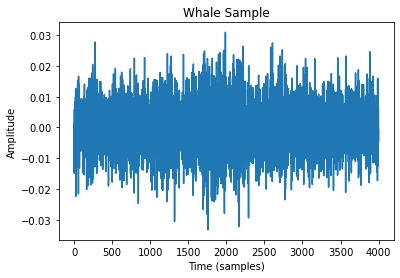

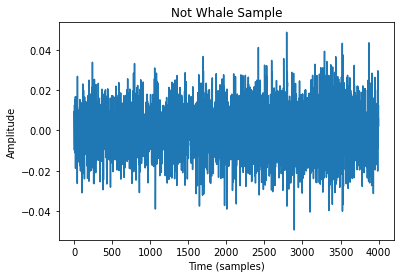

In [6]:
plt.plot(whale_audio)
# label the axes
plt.ylabel("Amplitude")
plt.xlabel("Time (samples)")
# set the title
plt.title("Whale Sample")
# display the plot
plt.show()

plt.plot(not_whale_audio)
# label the axes
plt.ylabel("Amplitude")
plt.xlabel("Time (samples)")
# set the title
plt.title("Not Whale Sample")
# display the plot
plt.show()

Notice that we have a total of 4000 samples since each recording has a sample rate of 2000Hz and a total length of 2 seconds.

Lets zoom in a bit to just the first hundred samples to take a closer look a small section of time.

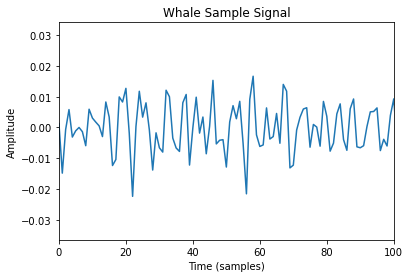

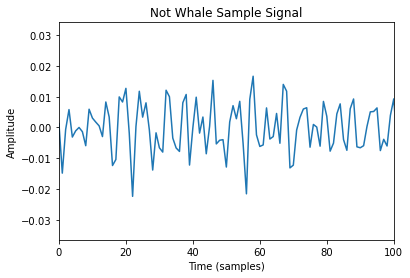

In [7]:
def plot_signal(audio, title):
  plt.plot(audio)
  # label the axes
  plt.ylabel("Amplitude")
  plt.xlabel("Time (samples)")
  # set the title
  plt.title(title)
  # display the plot
  plt.xlim(0, 100)
  plt.show()

plot_signal(whale_audio, "Whale Sample Signal")
plot_signal(whale_audio, "Not Whale Sample Signal")

## Frequency Analysis

To get a clearer picture of what is going on in the audio file, it is useful to examine the frequency content of the signal. To do this we will breakdown the original signal into its frequency components and plot it. Here we perform a Fast Fourier Transform on the signal and plot it. Now, we get a clearer picture of which frequencies are used in the sound file as well as their amplitude.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: scipy.log10 is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log10 instead
  


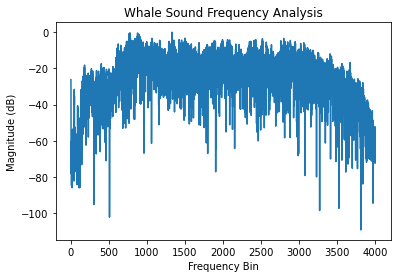

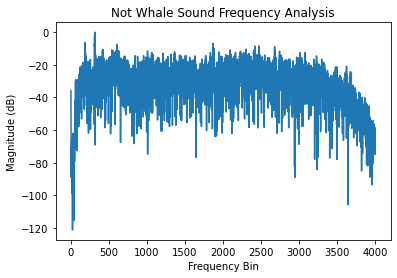

In [8]:
def plot_frequency(audio, title):
  # apply a Hanning window
  window = hann(4000)
  audio = audio * window
  # fft
  mags = abs(rfft(audio))
  # convert to dB
  mags = 20 * scipy.log10(mags)
  # normalise to 0 dB max
  mags -= max(mags)
  # plot
  plt.plot(mags)
  # label the axes
  plt.ylabel("Magnitude (dB)")
  plt.xlabel("Frequency Bin")
  # set the title
  plt.title(title)
  plt.show()

plot_frequency(whale_audio, "Whale Sound Frequency Analysis")
plot_frequency(not_whale_audio, "Not Whale Sound Frequency Analysis")

## Time-Frequency Analysis

What would be really useful would be to see which frequencies are active, and at what intensity, at a given point in time? Here we produce a spectrogram which gives us an image representing a breakdown of frequencies plotted against time. A bright color in the plot represents intense activity at that frequency at that time. This gives us a much more helpful picture where we can see in the middle the call of the whale going upwards in pitch.

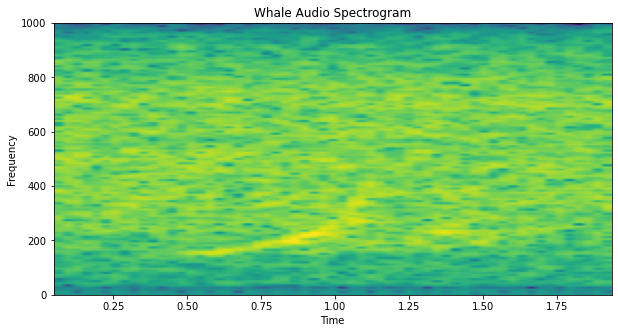

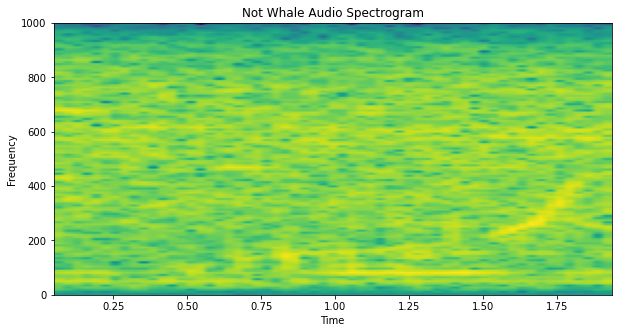

In [9]:
def show_spectrogram(audio, title):
  fs = 2000 # sampling frequency

  # Plot the spectrogram
  plt.figure(figsize=(10, 5))
  S, freqs, bins, im = plt.specgram(audio, NFFT=256, Fs=fs, noverlap=192)
  plt.xlabel('Time')
  plt.ylabel('Frequency')
  plt.title(title)
  plt.show()

show_spectrogram(whale_audio, "Whale Audio Spectrogram")
show_spectrogram(not_whale_audio, "Not Whale Audio Spectrogram")

# Cornell Lab of Ornithology Buoy System

The Cornell Lab of Ornithology used a bouy platform from the Woods Hole Oceanographic Institution. The WHOI platform components included mooring, a hydrophone, a power system, surface expression, and antennae. They also included Cornell components such as housing, analog interface hardware, GPS, an embedded computer, a detection engine, and telemetry hardware. The bouy hardware/software system would rank 2s sound clips as potential North Atlantic Right Whale candidates and would upload the clip along with meta data such as location, timestamp, and more via a satellite for shore-side processing.

## Reading a Spectogram

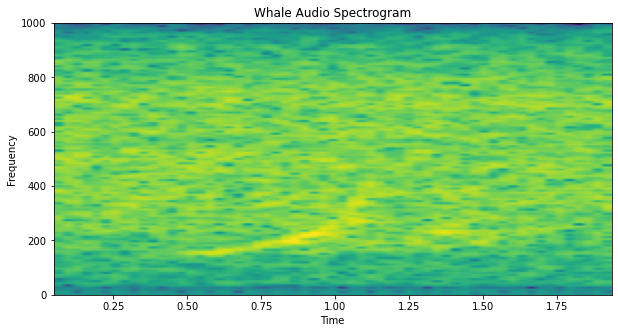

In [10]:
show_spectrogram(whale_audio, "Whale Audio Spectrogram")

Recall the image above as the 'image' of what a NARW (North Atlantic Right Whale) call looks like. This image is called a spectogram and what it shows is the activity of a signal in the frequency domain plotted against time. Notice the brighter spot in the 0.5 - 1 second time range. That represents a NARW up-call as it goes up in frequency over time. The more intense the pixels in a region, the more activity in that corresponding frequency is going on at that particular time. We notice that a whale call has an upward trajectory in frequency.

## Early Detection Methods 2005-2007

Input from a hydrophone (underwater microphone) is input into an analog to digital converter. The magnitude-squared discrete fourier transform spectogram is computed from the signal.

In order to detect a NARW up-call the spectrogram is processed by Doug Gillespie's NARW upsweep detector. Essentially, an estimate for the background level of noise is formed. The detector would check from time-frequency cells with energy greater than an integer multiple of the background energy estimate. Cells with energy over this level were grouped in time and frequency (called candidate events). A numerical score from 2-10 was given to each event based on the duration of the event, min/max frequency, sweep frequency, position of min/max Hz, and max bandwidth. If the score of the event exceeded a threshold then its time and sore were stored. Low scoring events were constantly being replaced by better scoring events. After all of this only the 10 best scoring clips were to be stored in long term bouy memory. These clips would then be uploaded shore-side where experts manually annotate whether or not a whale was present in the clip.

# Kaggle Competition

In 2013, The Cornell Bioacoustics Research Program and Marinexplore held a public data science contest to come up with new solutions to NARW detection. A variety of different approaches were used by different teams. The benchmark score to beat was 0.7 ROC AUC. The method to get that score was based on the existing system in place today by Cornell, outlined above. The winning solution managed to get a score of 0.981 ROC AUC which is a significant improvement.

## Winning Approach

The winning approach meets the objective by finding an automatic way of detection NARW up-calls without the need for experts to have to sit through and manually label incoming events.

### Template Matching

#### Motivation

By looking at a large number of images of spectrograms of whale calls, patterns start to emerge. Most whale calls exist in a frequency range of 50hz-400hz. Most whale calls also include an upword trajectory in pitch. Differences exist in the slope of the trajectory and the length of the call. The winning approach uses the notion that most whale calls "look" alike, when looked at in a spectrogram, and tries to use that to it's advantage. Rather than pass an entire image (of the spectrogram) to a classification algorithm, they pass a small list of features derived from template matching (and other metrics). 

#### How does it work?

Template matching finds areas of an image that are similar to a template image. The template image is often called a patch. 

Two components are needed:
* A Source image
* Template image
    
The goal is to detect the highest matching area of a source image.

To find a matching area, you overlay the template image over the source image and compare the areas. The comparison is given a score and is stored in a result matrix R at the index (x,y) corresponding to the current rectangle formed with top left corner at location (x,y) in the source image. After the comparison is made, the method then slides the template over one pixel and compares against that rectangle. This process continues for all pixels in the source image.

A score is then calculated from this.

#### How were templates generated?

If a training sample did not correlate to any template well, then that training sample was converted to a template. This process was repeated until most training samples matched templates. This process was not automatic and was done manually. The template file read in by this method was merely a filename of an image, an x0 and xN positions (start and finish, x-axis), and a y0 and yN positions (start and finish, y-axis). Together these positions represent a rectangle inside a given image file.

##### Pre-Processing the Spectrogram Before Template Creation

Before using a given rectangle of an image as a template, they did a few pre-processing steps.

First was to demean the image.

What this does is to cut off extreme values and remove the mean at a given pixel. This enhances the contrast vertically along the frequency dimension.

The next step was to normalize the image.

Afer that, the image was turned into a binary mask. Pixels were rounded to 1 if the intensity was greater than 0.5 and to 0 if less than 0.5.

##### A step-by-step example:

Get Spectrogram

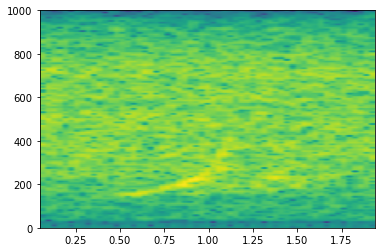

In [11]:
P, freqs, bins, im = plt.specgram(whale_audio, NFFT=256, Fs=whale_samplerate, noverlap=192)

Vertically Demean

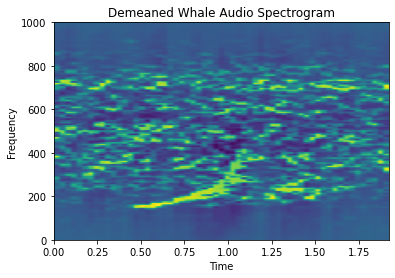

In [12]:
def show_spectrogram_from_components(P, freqs, bins, title):
    Z = np.flipud(P)
    xextent = 0, np.amax(bins)
    xmin, xmax = xextent
    extent = xmin, xmax, freqs[0], freqs[-1]
    im = plt.imshow(Z, extent=extent)
    plt.axis('auto')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()
    
    
    
def slidingWindowV(P,inner=3,outer=64,maxM = 50,norm=True):
    Q = P.copy()
    m, n = Q.shape
    if norm:
        mval, sval = np.mean(Q[:maxM,:]), np.std(Q[:maxM,:])
        fact_ = 1.5
        Q[Q > mval + fact_*sval] = mval + fact_*sval
        Q[Q < mval - fact_*sval] = mval - fact_*sval
    wInner = np.ones(inner)
    wOuter = np.ones(outer)
    for i in range(n):
        Q[:,i] = Q[:,i] - (np.convolve(Q[:,i],wOuter,'same') - np.convolve(Q[:,i],wInner,'same'))/(outer - inner)
    return Q[:maxM,:]

m, n = P.shape
P = slidingWindowV(P,maxM=m)
show_spectrogram_from_components(P, freqs, bins, "Demeaned Whale Audio Spectrogram")

Normalize and Turn into Binary Mask

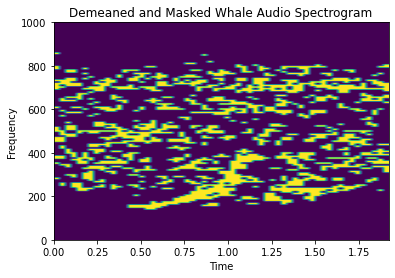

In [13]:
def normalize_mask(P):
    P_dm = P.astype('float')
    m_, s_ = np.mean(P_dm), np.std(P_dm)
    min_ = P_dm.min()
    P_dm[ P_dm < m_ + 0.5*s_] = min_ 
    P_dm[ P_dm > min_ ] = 1
    P_dm[P_dm < 0] = 0
    return P_dm

show_spectrogram_from_components(normalize_mask(P), freqs, bins,  "Demeaned and Masked Whale Audio Spectrogram")

Cut out a Rectangle

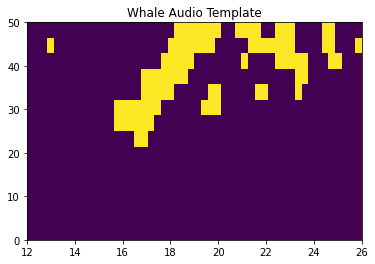

In [14]:
def plot_template(P, title):
    x0=12
    xn=26
    y0=0
    yn=50
    
    P_cropped = P[x0:xn,y0:yn].astype('float')
    P_t = normalize_mask(P_cropped)
    
    Z = np.flipud(P_t)
    extent = x0, xn, y0, yn
    plt.figure()
    im = plt.imshow(Z, extent=extent)
    plt.axis('auto')
    plt.xlim([x0, xn])
    plt.ylim([y0, yn])
    plt.title(title)
    plt.show()
    
plot_template(P, "Whale Audio Template")

#### Generating a Feature from Matching

When template matching is called on a source image and template, the result is the (x,y) coordinate with the maximum correlation to the template as well as the score it obtained. There are many different scoring formulas but the one used in this solution is the equation mentioned above. This process is repeated for every template. Therefore what they end up with is a list of how well an image correlates to a template, for every template.

### Other Metrics

Other metrics used as features were the centroid, width, skew, and total variation of a time slice of frequencies. Another metric used was the order of the files. This ordering metric exploits an anonamaly in the dataset in which sequential files were also sequential in time. If a whale was detected in the previous file, it would increase the probability that a whale was in the next because it was likely that the same whale were to make a sound again. The template matching was also used again as another metric but focusing on the high frequencies in the spectrogram.

### Classification

After all of this feature generation, the results are sent to a Gradient Boosting Classifier.

Gradient Boosting is a machine learning tecnique for regression problems. It produces a prediction model in the form of an ensemble of weak prediction models. Gradient boosting predictors are built in a stage-wise fashion. Gradient boosting is used for classification by reducing the classification task to a regression problem with a suitable loss function.

### Results

The method outline here received a 0.981 ROC AUC score. It received an even higher score when temporal information in the file naming was used as a feature. Files in the dataset were numbered sequentially, and incidently were also chronologically ordered. What ended up happening was that clusters of whale calls would appear in proximity to each other temporaly, represented as filenames that were close to each other. By utilizing this information, the score jumped to 0.9838.

## Evaluation Criteria

### Area under the Receiver Operating Characteristic Curve

From Wikipedia - Receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings.

The AUC is the area of the region underneath this curve.

In other words, the ROC Curve is the sensitivity (true positives rate) plotted against false positives rate (1-specificity) as the discrimination threshold is varied.

True positive rate is also called sensitiviy, recall, or hit-rate.

$$
tprate=\frac{\text{Positives correctly classified}}{\text{Total positives}}
$$

The false positive rate (also called false alarm rate) of the
classifier is

$$
fprate=\frac{\text{Negatives incorrectly classified}}{\text{Total negatives}}
$$

In other words, imagine you had a method of predicting whales calls that would output the probability of the sound being a whale call. At which value do you set a cut off? Most systems use 0.5 as the default. What this means is that any prediction at or above 0.5 would be considered a whale and anything below would not be a whale. What if 0.4 is a better threshold? In order to evaluate the performance of a classifier (and not a given threshold), ROC AUC tries every possible threshold and plots the true positive rate over false positive rate at each of these thresholds. It then determines the area under that curve and uses that as the score. The score ranges from 0 to 1. An ROC AUC score of 0.5 is the equivalant discrimination power as flipping a fair coin.

# Eric's Convolutional Neural Network Approach

## Why Deep Learning

Deep learning is the process of learning hierarchies of features. Deep learning methods aim at learning feature hierarchies with features from higher levels of the hierarchy formed by the composition of lower level features. By learning features at multiple levels of abstraction, the system can learn complex features that we humans might not have been able to explicity express. These complex features are learned by complex non-linear functions. By forming deep architectures, the system learns complex functions mapping the input to the output, directly from data. This allows us to learn powerful features without the need for expert domain knowledge and human-crafted features.

The standard model of the visual cortex (Hubel and Wiesel 1962; Serre et al. 2005; Ranzato et al. 2007) suggest that (roughly speaking) the brain first extracts edges, then patches, then surfaces, then objects, etc. This observation is the motivation behind the recent trend in deep learning research.

## Neural Networks

Neural Networks are models inspired by animal central nervous systems (in particular the brain) that are capable of machine learning and pattern recognition. The first generation of neural networks, called perceptrons, were introduced in 1957 by Frank Rosenblatt. They were deemed ineffective by the artificial intelligence community. Recently, neural networks have made a comeback as we now have more tools to properly train them.

## Convolutional Neural Networks

Convolutional Neural Networks (CNN) are variants of Multi-layer Perceptrons. They are modeled after Hubel and Wisel's early work on the cat's visual cortex. They are designed to recognize visual patterns directly from pixel images with minimal preprocessing. They can recognize patterns with extreme variability, and with robustness to distortions and simple geometric transformations.

### High Level Overview

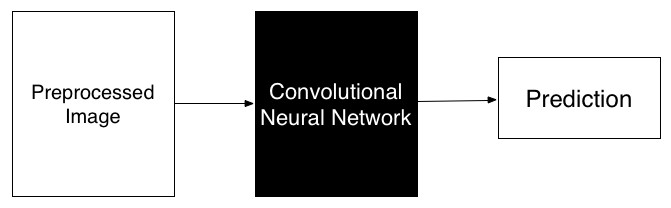

In [84]:
display.Image("images/highleveloverview.jpeg")

### Pre-processing

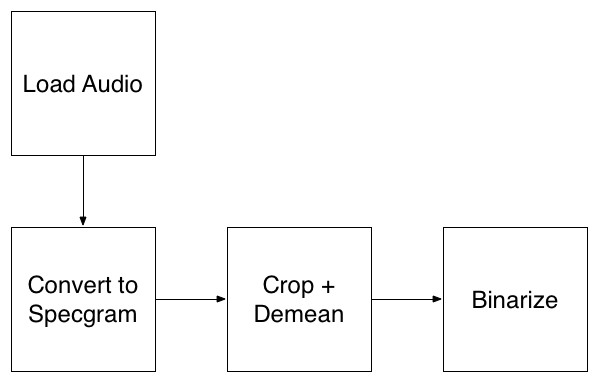

In [86]:
display.Image("images/preprocessing.jpeg")

A convolutional neural network takes images as input. First, I take every audio file in the training set and compute the spectrogram. Next, I cut off frequencies above 400hz as the whale call we are trying to detect lies in the 50hz to 400hz range. These images are then resized to 40x59 pixel images. The next step is to vertically demean the spectrogram which helps remove noise from the image. After this step, the spectrogram is normalized and turned into a binary mask by rounding every pixel to the nearest integer 0 or 1. The inspiration for doing this type of preprocessing comes from Nicholas Kridler who used this same preprocessing step of demeaning and normalizing in his solution.

### Architecture

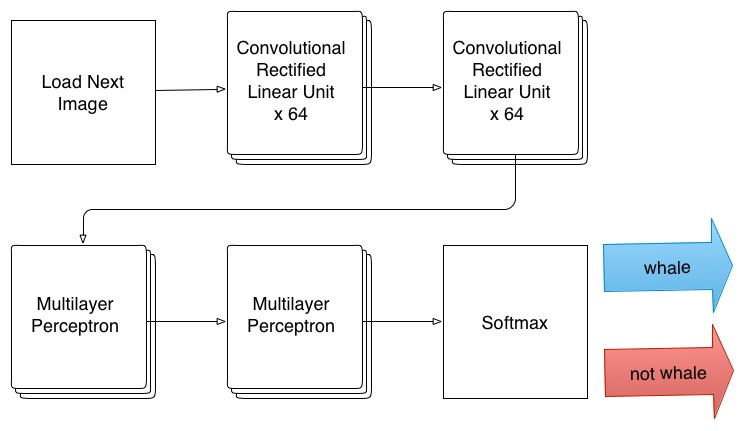

In [87]:
display.Image("images/architecture.jpeg")

### Perceptron (Neuron)

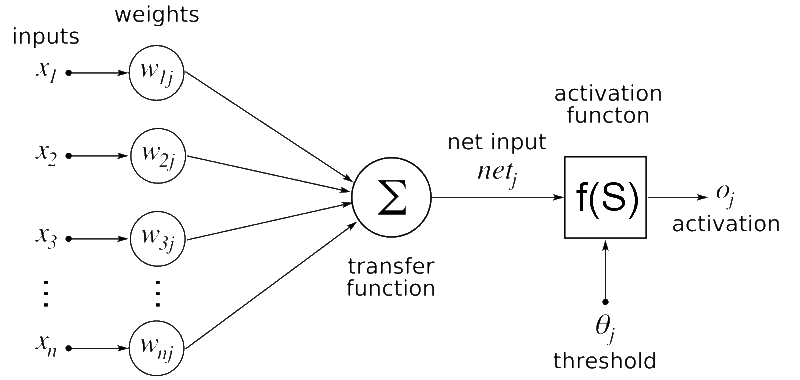

In [88]:
display.Image(filename='images/artificialneuron.png')

The basic unit of a neural network is a neuron. A neuron is a function with that takes in multiple inputs, a weight for each input, and a threshold term. These inputs are the inputs to an activation function, by way of the transfer function. The transfer function normally is just summation. The threshold term is used by the activation function. When the output is below the threshold, the deactivated value (typically 0 or -1) is sent. When the value is above or at the threshold then the activated value (typically 1) is sent. Typically the activation function chosen is either the sigmoid or hyperbolic tangent function. The reason for this is that their output lies in a nice range [0,1] and [-1, 1], respectively. Another reason for their selection is that their derivative is easy to compute, which is necessary for backpropagation. The goal for a single neuron system trained with backpropogation is to learn a set of weights such that the output of the activation function is the correct label (when thresholded or rounded for classification) or the correct value (for regression tasks). 

### Convolution

Convolution is a mathematical operation on two functions, producing a third function that is typically viewed as a modified version of one of the original functions, giving the area overlap between the two functions as a function of the amount that one of the original functions is translated. Convolution can be useful for algorithms involving edge detection. It is used to learn edges in early layers. Then later to form higher level feature collections like eyes and shapes.

_Lena was a common example used in literature_

Load a picture of Lena for example: 

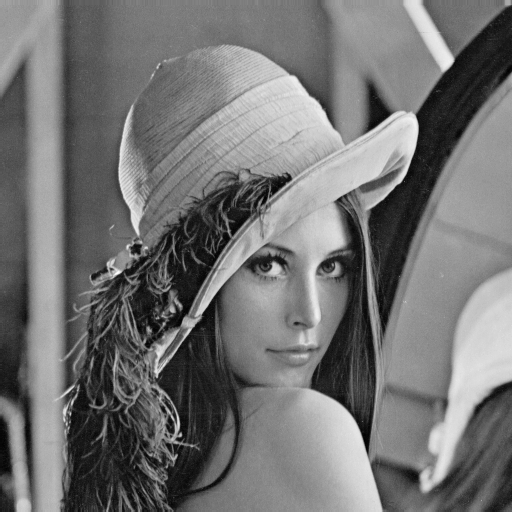

In [89]:
display.Image(filename='images/lena.png')

Here are four Gabor filters that we will convolve Lena with.

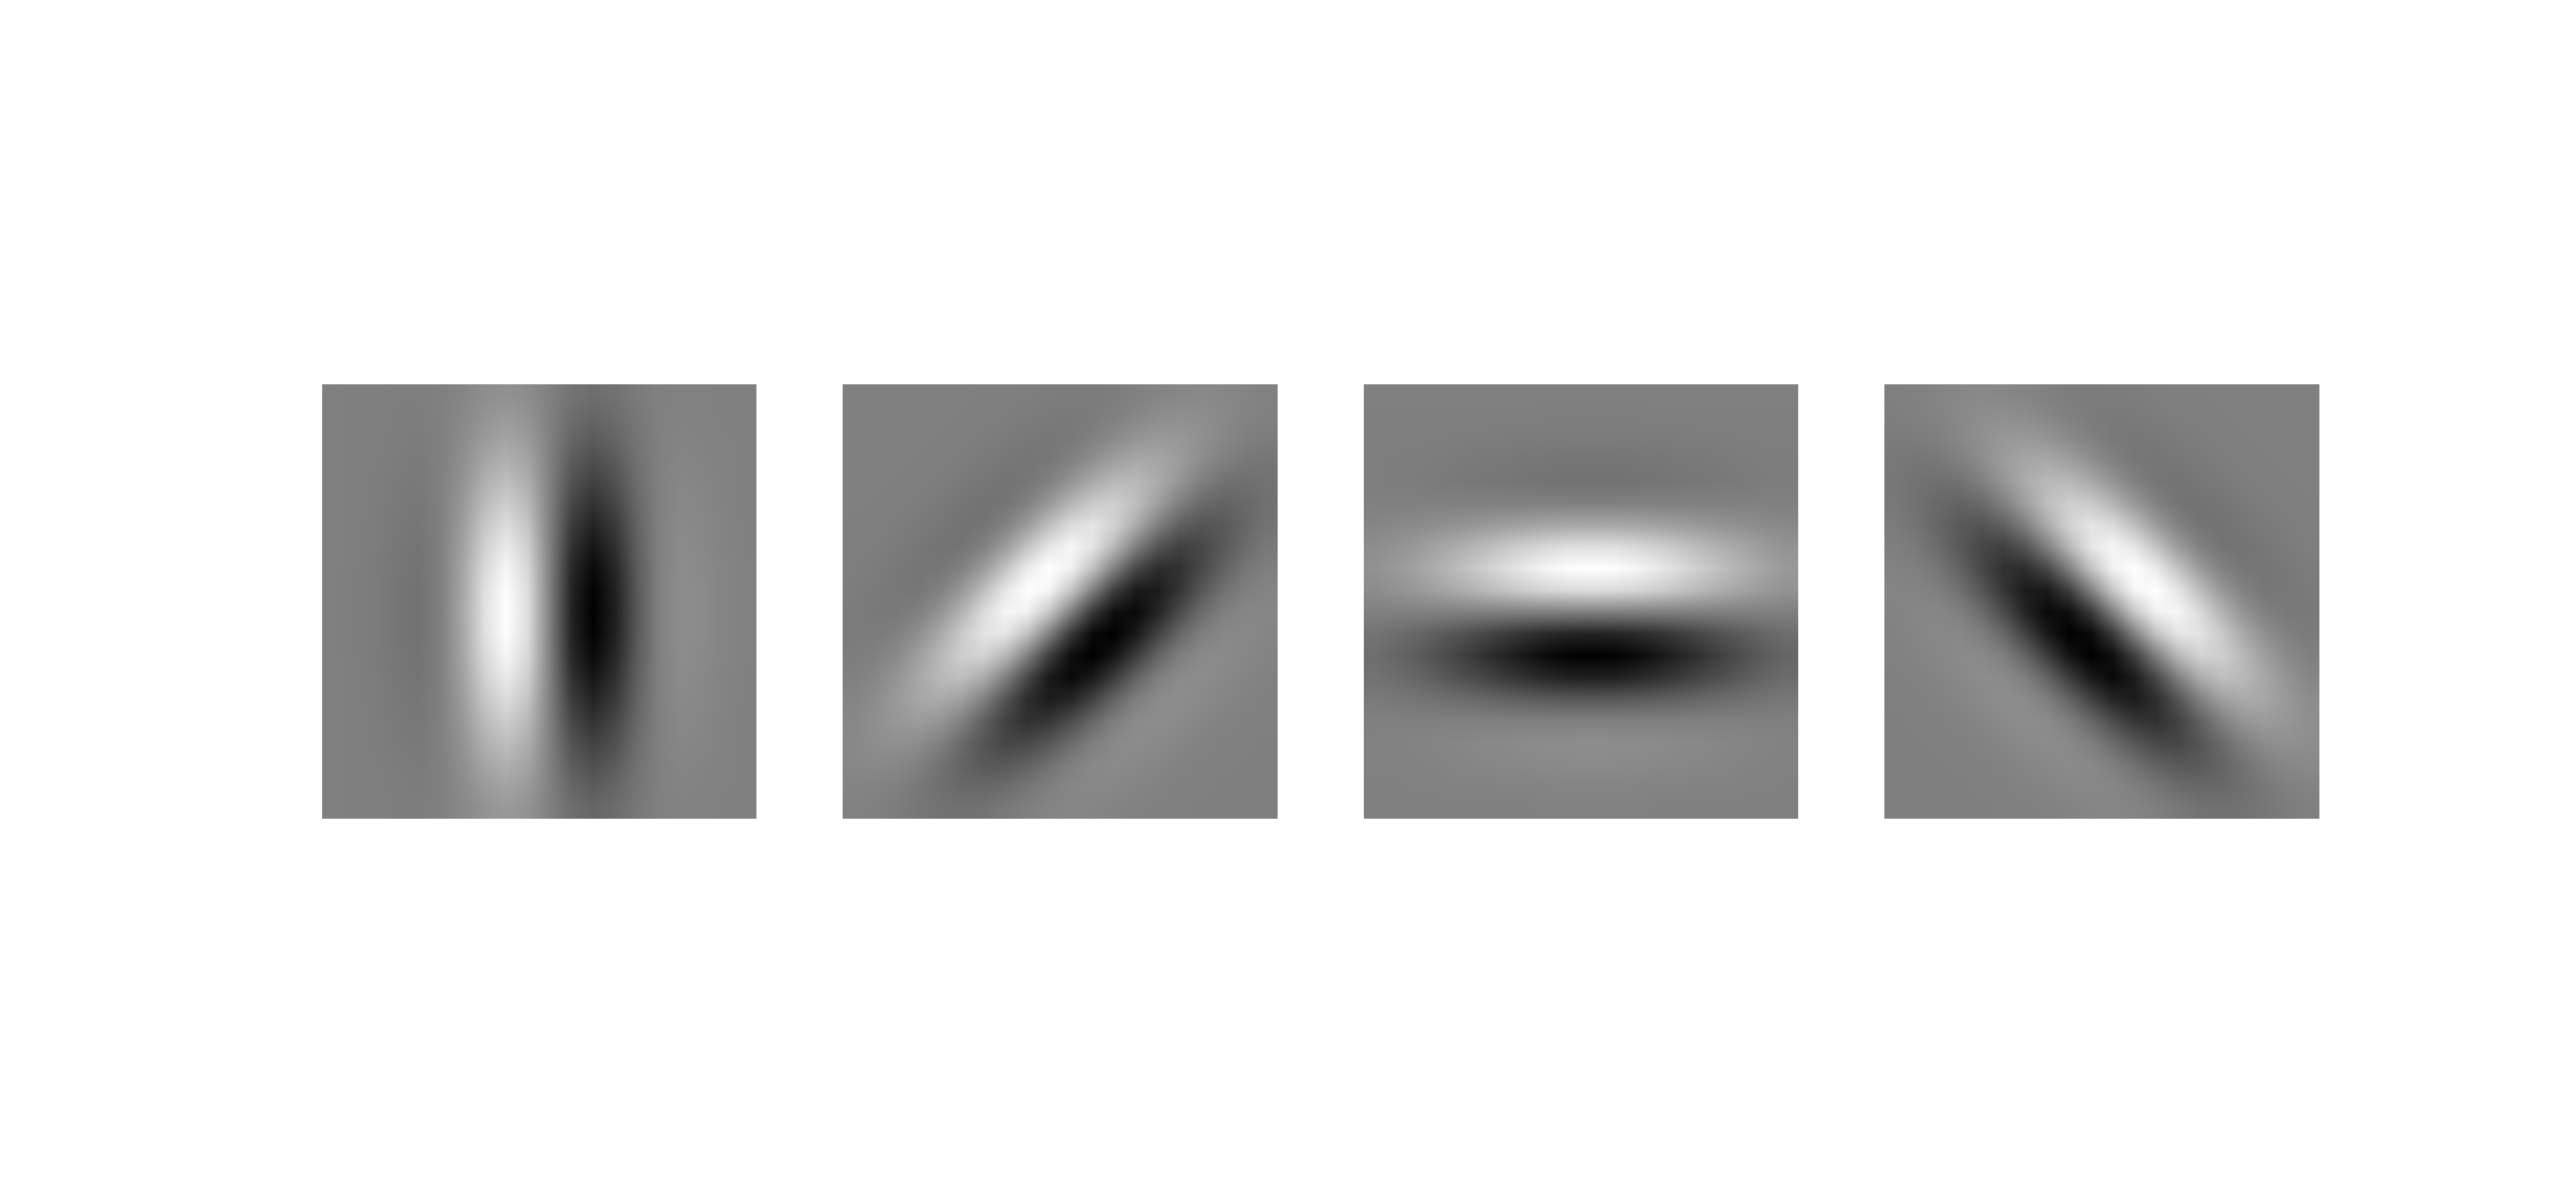

In [92]:
display.Image("images/gaborfilters.png")

Output after convolving Lena with the four filters.

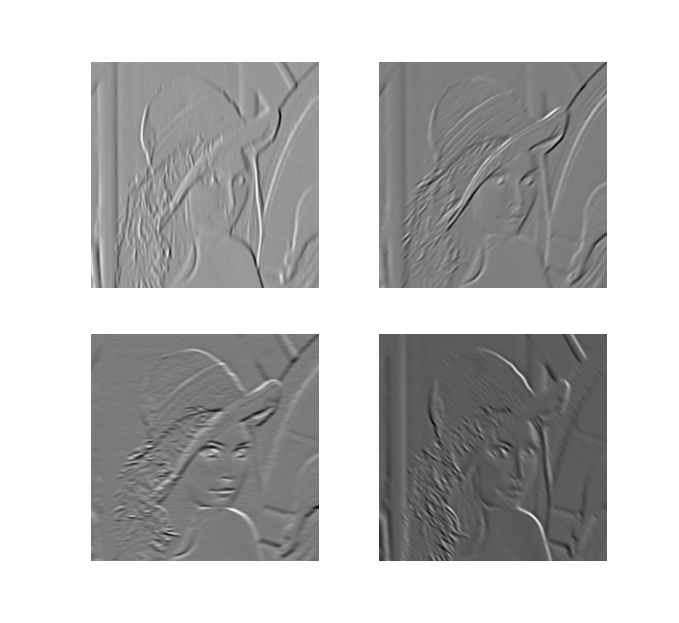

In [93]:
display.Image("images/lenaconvolved.png")

### Subsampling with Pooling

Subsampling with max-pooling is the process of taking every X by X pixels and averaging them together, and discarding the original X by X pixels in order to reduce the resolution and size of an image. Effectively, we can refer to this as resizing an image to a smaller representation. This is very useful for taking large images and reducing the dimensionality while retaining high-level information.

### Classification

Classification is the process of receiving input data and predicting the label of the class it belongs to. For the purposes of this project, each file in the training set is labeled as a whale sound or not a whale sound. The job of the classifier is to take input from the feature extractors and predict whether or not the original input was a whale sound or not a whale sound. Convolutional neural networks typically use a simple classification method such as logistic regression.

### Backpropagation

The job of backpropogation is to take the prediction and compute its squared-error. After computing the squared error it adjusts the weights to the last layer of the neural network so that its output is correctly classified. It then propogates the squared-error back up to the previous layer so that it can also adjust its weights. It does this for every layer in the network, typically using an algorithm like gradient descent to adjust the weights. 

### Architecture details (Based on Lenet5)

#### First layer - 64 Convolutional Rectified Linear Units

The input image is split up into 64 parts. Each of these parts mapping to each of the convolutional rectified linear units. The convolutional rectified linear unit performs convolution with the input against a kernel as well as the subsampling with pooling all in one layer. The output of this layer now represents a subsampled and convolved version of the original input.

#### Second layer - 64 Convolutional Rectified Linear Units

This new image is split up again into 64 parts. Each of these parts mapping to each of the convolutional rectified linear units. This layer also performs convolution against a learned kernel as well as subsampling with pooling all in one layer. At this point the dimensionality of the data should be reduced down into simple extracted features.

#### Third layer - Multilayer perceptron (500 units)

The third layer contains a fully-connected multilayer perceptron. The perceptron applies a set of weights to the input and applies an activation function. It this single value as its output.

#### Fourth layer - Multilayer perceptron (500 units)

The fourth layer contains another fully-connected multilayer perceptron. The perceptron applies a set of weights to the output of the previous layer. It then outputs the value applying the activation function.

#### Fifth layer - Softmax

The softmax layer is simple. It simply accepts as input the output of the previous layer and outputs a binary decision for each label. In this case for the "whale" label it outputs a 0 or 1. This is accomplished by rounding the input. For the "not whale" label it merely does the inverse.

## Initialization and Training

In order to get the process started, every weight and kernel is randomly initialized. When an image is sent down the network during training, the output at the end is compared to the expected output (the real label). A process called stochastic gradient descent sends the error backwards so that every unit can have its weight adjusted so that the network output the correct prediction for the particular example. With enough examples, the system learns a robust set of kernels and weights for prediction.

#### Preventing overfitting
In order to prevent overfitting and the co-adaption of feature detectors, a technique known as dropout is employed. At every training step, 20 percent of the features are ignored. This technique, pioneered by Geoffrey Hinton, has created state-of-the-art results on benchmark datasets. This technique forces feature detectors to learn stronger representations using less data.

####  Storing and accessing data

We store our data in HDF5 datasets using the H5PY library in Python. This allows us to store our data on disk, instead of RAM, which is good for large datasets. Pylearn2, requires data in the form of an object of type DenseDesignMatrix which provides special handlers for dealing with the dataset. A simple wrapper is created to wrap the HDF5 datasets as a DenseDesignMatrix.

### Hidden Layers

There are two hidden layers to the neural network. Both contain a convolution layer and a subsampling layer in the form of a single ConvRectifiedLinear layer. These layers make the neural network invariant to small changes such as translation or scale.

### PyLearn2 Config

In [ ]:
yaml="""!obj:pylearn2.train.Train {
    dataset: &train !obj:whale.Whale {
        which_set: 'train',
    },
    model: !obj:pylearn2.models.mlp.MLP {
        batch_size: 100,
        input_space: !obj:pylearn2.space.Conv2DSpace {
            shape: [40, 59],
            num_channels: 1
        },
        layers: [ !obj:pylearn2.models.mlp.ConvRectifiedLinear {
                     layer_name: 'h0',
                     output_channels: 64,
                     irange: .05,
                     kernel_shape: [5, 5],
                     pool_shape: [4, 4],
                     pool_stride: [2, 2],
                     max_kernel_norm: 1.9365
                 }, !obj:pylearn2.models.mlp.ConvRectifiedLinear {
                     layer_name: 'h1',
                     output_channels: 64,
                     irange: .05,
                     kernel_shape: [5, 5],
                     pool_shape: [4, 4],
                     pool_stride: [2, 2],
                     max_kernel_norm: 1.9365
                 }, !obj:pylearn2.models.mlp.Sigmoid {
                     layer_name: 'h2',
                     dim: 500,
                     sparse_init: 15,
                 }, !obj:pylearn2.models.mlp.Sigmoid {
                     layer_name: 'h3',
                     dim: 500,
                     sparse_init: 15,
                 }, !obj:pylearn2.models.mlp.Softmax {
                     max_col_norm: 1.9365,
                     layer_name: 'y',
                     n_classes: 2,
                     istdev: .025
                 }
                ],
    },
    algorithm: !obj:pylearn2.training_algorithms.sgd.SGD {
        batch_size: 100,
        learning_rate: .01,
        init_momentum: .5,
        monitoring_dataset:
            {
                'test'  : !obj:whale.Whale {
                              which_set: 'test',
                          }
            },
       cost: !obj:pylearn2.costs.mlp.dropout.Dropout {
            input_include_probs: {
                'h0' : .8,
                'h2' : 0.5,
                'h3' : 0.5
                },
            input_scales: {
                'h0': 1.,
                'h2': 1.,
                'h3': 1.
            }
        },
        termination_criterion: !obj:pylearn2.termination_criteria.And {
            criteria: [
                !obj:pylearn2.termination_criteria.MonitorBased {
                    channel_name: "test_y_misclass",
                    prop_decrease: 0.,
                    N: 100
                },
                !obj:pylearn2.termination_criteria.EpochCounter {
                    max_epochs: %d
                }
            ]
        }
    },
    extensions:
        [ !obj:pylearn2.train_extensions.best_params.MonitorBasedSaveBest {
             channel_name: 'test_y_misclass',
             save_path: "convolutional_network_best.pkl"
        }, !obj:pylearn2.training_algorithms.sgd.MomentumAdjustor {
            start: 1,
            saturate: 10,
            final_momentum: .99
        }
    ]
}
""" % epochs

### Results

In order to properly evaluate the performance of my network it was necessary to compare against a known good solution. I chose Nicholas Kridler's solution to compare to as the code is publicly available and the best known method for solving this problem. I modified his solution architecturally to distribute work across CPU cores for faster performance. The other modification I made was to remove the ordering metric from the data so that we could judge how accurately his solution could discriminate given only a single audio file with no prior information about what occurred in the past. The reason for this is that if we want to take random slices and permutations of the dataset for creating a training and testing set then the order of the files is random, not sequential, and would only corrupt predictions by using it as a metric.

For the experiments, the full dataset was randomly shuffled and split into halves for training and testing. We would use those same training and testing sets on both solutions. Each run, however, would generate a new random training and testing set for use on both solutions.

The template matching solution scored 0.9239 ROC AUC. My method scored 0.9671 ROC AUC on the same training and testing set.

### Discussion

Although marginal, it demonstrates that it is possible to automatically learn features from this data without the need for expert knowledge in the domain. It also demonstrates that these automatically learned features can approach and even beat out features that are manually chosen by humans.

This result also validates the use of convolutional neural networks as a state-of-the-art method for machine learning on bioacoustic datasets.

During the Kaggle competition, many teams used convolutional neural networks but were not able to beat the score of the template matching solution. It is my opinion that this was due to better preprocessing.

By reducing all files to binary masks, it is easier for a system to learn when it can ignore pixels with low intensity and only look at pixels with high intensity. From there, background noise is greatly reduced and a system has an easier time learning patterns from a binary image. By incorporating this type of preprocessing into my neural network made a large improvement in prediction ability.

### Goals Accomplished

The goals I accomplished for this project were to beat a 0.7 ROC AUC score which is approximately the score that Cornell and NOAA currently get with their existing solution. More importantly, I matched and exceeded the solution by Nicholas Kridler, currently the best method for solving this problem. A major goal I had was the idea of creating a system that could automatically learn features from the data with no expert knowledge. The solution by Nicholas Kridler uses manually labeled templates that were cut from expert knowledge. My solution, on the other hand, infers no prior knowledge of the domain.

### Goals Not Accomplished

A goal I had in the beginning was that I would develop a system that would automatically learn templates from the data to be used with the solution by Nicholas Kridler. This would make the system from Nicholas Kridler to be used without previous knowledge of the domain. It would make it more automatic and perhaps improve the score. The first layer of a neural network learns templates from the data. I integrated these templates, after training the neural network, but achieved terrible performance. This goal ultimately failed because the templates learned at the first layer of the neural network are not suitable for use in template matching. The templates are learned as kernels to be used for edge detection during convolution. This made them perform poorly as straight templates for template matching.

#### Relevant Literature

Bengio, Yoshua. "Learning deep architectures for AI." _Foundations and trends® in Machine Learning_ 2.1 (2009): 1-127.

LeCun, Yann, et al. "Gradient-based learning applied to document recognition."_Proceedings of the IEEE_ 86.11 (1998): 2278-2324.

Hinton, Geoffrey E., et al. "Improving neural networks by preventing co-adaptation of feature detectors." _arXiv preprint arXiv:1207.0580_ (2012).

Hubel, David H., and Torsten N. Wiesel. "Receptive fields, binocular interaction and functional architecture in the cat's visual cortex." _The Journal of physiology_ 160.1 (1962): 106.
